# 4.一阶卡尔曼滤波器

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

现在我们理解了离散贝叶斯滤波和高斯分布，我们准备实现卡尔曼滤波器。我们将像实现离散贝叶斯滤波器那样进行操作 - 而不是从方程式开始，而是基于对问题的推理逐步开发代码。

"一维"意味着滤波器只跟踪一个状态变量，比如x轴上的位置。在随后的章节中，我们将学习一种更通用的多维形式的滤波器，它可以同时跟踪许多状态变量，比如位置、速度和加速度。回想一下，在g-h滤波器中，我们使用速度来获得比仅跟踪位置更好的估计值。卡尔曼滤波器也是如此。

那么为什么不直接进入滤波器的多维形式呢？说实话，数学很困难，而我对开发滤波器的直觉方法开始失效。这种数学让卡尔曼滤波器工作原理变得不简单。

因此，在本章中，我们学习如何使用高斯分布来实现贝叶斯滤波器。卡尔曼滤波器只是一个使用高斯分布的贝叶斯滤波器。在下一章中，我们将转向多维形式，卡尔曼滤波器的全部威力将被释放！

# 问题描述

和“离散贝叶斯滤波器”章节一样，我们将在工作中的一条长走廊上跟踪一个移动的物体。假设在我们最近的黑客马拉松中，有人创建了一个RFID跟踪器，可以提供狗的相对准确位置。传感器返回狗距离走廊左端的距离，以米为单位。所以，23.4意味着狗距离走廊左端23.4米。

然而，传感器并不完美。一个读数为23.4可能对应着狗在23.7或者23.0的位置。但很不可能对应着狗在47.6的位置。在黑客马拉松期间的测试证实了这一点——传感器“相当”准确，虽然存在误差，但误差很小。此外，误差似乎均匀地分布在真实位置的两侧；一个位置是23米，同样可能被测量为22.9或23.1。也许我们可以用高斯分布来模拟这种情况。

我们预测狗在移动。这个预测并不完美。有时我们的预测会超出，有时会不足。我们更可能小幅度地高估或低估，而不是大幅度。也许我们也可以用高斯分布来模拟这一点。

# 高斯表示

我们可以用一个高斯分布来表达对狗位置的信念。假设我们相信狗在10米处，信念的方差为1平方米，即$\mathcal{N}(10,\, 1)$。以下是概率密度函数的图表：

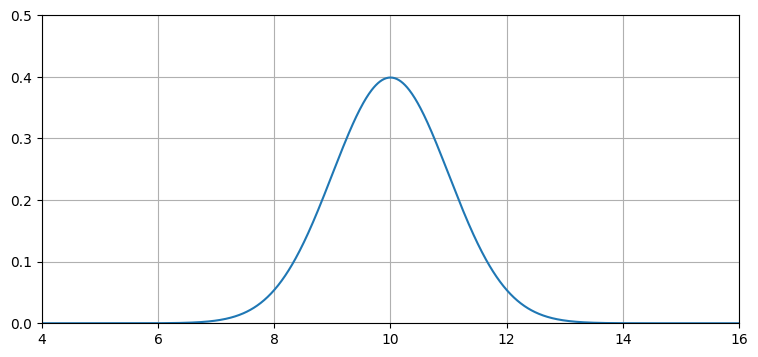

In [3]:
import filterpy.stats as stats
stats.plot_gaussian_pdf(mean=10., variance=1., 
                        xlim=(4, 16), ylim=(0, .5));

这个图表描述了我们对狗位置的不确定性。它代表了一个相当不精确的信念。虽然我们相信狗最可能在10米处，但从9米到11米左右的任何位置也是相当可能的。假设狗站在原地，我们再次查询传感器。这次传感器返回10.2米。我们能利用这个额外信息来改进我们的估计吗？

直觉告诉我们可以。考虑一下：如果我们读取传感器500次，每次返回值都在8到12之间，且都集中在10附近，那么我们应该非常有信心认为狗在10附近。当然，也可能有不同的解释。也许我们的狗是随机来回漫步，恰好模拟了从正态分布中随机抽取的情形。但这似乎极不可能——我从未见过狗这样做。让我们看一看从$\mathcal N(10, 1)$抽取的500个数值：

Mean of readings is 10.054


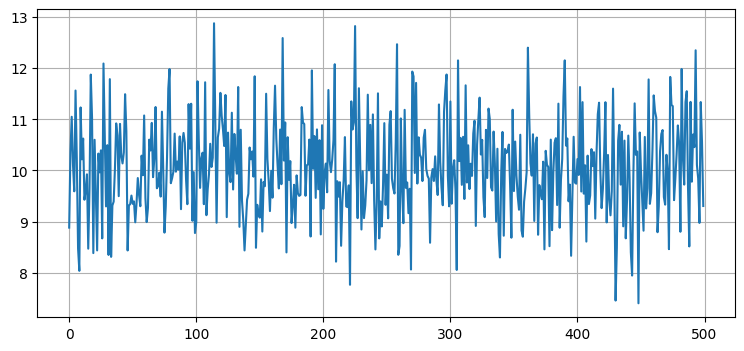

In [4]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = randn(500)*1. + 10.
plt.plot(xs, ys)
print(f'Mean of readings is {np.mean(ys):.3f}')

粗略看一下验证了我们的直觉——没有狗会移动得像这样。然而，嘈杂的传感器数据确实呈现这种情况。计算得到的读数平均值几乎正好是10。假设狗在原地静止不动，我们说狗在位置10，方差为1。

# 用高斯概率进行轨迹追踪

离散贝叶斯滤波器使用概率直方图来跟踪狗的位置。直方图中的每个柱代表一个位置，其值是狗在该位置的概率。

跟踪是通过预测和更新的循环来执行的。我们使用下面的方程来计算新的概率分布：

$$\begin{aligned} 
\bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{预测} \\
\mathbf x &= \mathcal L \cdot \bar{\mathbf x}\, \, &\text{更新}
\end{aligned}$$

这些方程用于计算新的概率分布。回想一下，$\bar{\mathbf x}$ 是*先验*，$\mathcal L$ 是在给定先验 $\bar{\mathbf x}$ 的情况下测量的*似然度*，$f_{\mathbf x}(\bullet)$ 是*过程模型*，$\ast$ 表示*卷积*。$\mathbf x$ 是粗体表示，表示它是一个数字的直方图，或者说是一个向量。

这种方法有效，但会导致直方图显示狗可能同时出现在多个位置。此外，对于大型问题，计算速度非常慢。

我们能否用高斯分布 $\mathcal N(x, \sigma^2)$ 替换直方图 $\mathbf x$？当然可以！我们已经学会了将信念表示为高斯分布。一个高斯分布，即一个数值对 $\mathcal N(\mu, \sigma^2)$，可以替换掉整个概率直方图：

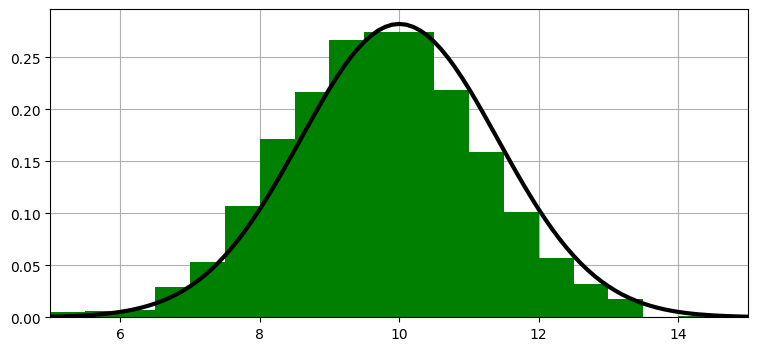

In [5]:
import kf_book.kf_internal as kf_internal
kf_internal.gaussian_vs_histogram()

希望你能看到这种方法的威力。我们可以用一个数值对 $x = \mathcal N(\mu, \sigma^2)$ 替换成数以百计甚至上千的数字。

高斯分布的尾部在两侧延伸至无穷远，因此它包含了直方图中任意多个柱的信息。如果这代表我们对走廊中狗位置的信念，那么这一个高斯分布就覆盖了整个走廊（以及在这个轴上的整个宇宙）。我们认为狗很可能在10米处，但它也可能在8米、14米，甚至以无穷小的概率在10的80次方米处。

在这一章中，我们用高斯分布替代了直方图：

$$\begin{array}{l|l|c}
\text{discrete Bayes} & \text{Gaussian} & \text{Step}\\
\hline
\bar {\mathbf x} = \mathbf x \ast f(\mathbf x) & 
\bar {x}_\mathcal{N} =  x_\mathcal{N} \, \oplus \, f_{x_\mathcal{N}}(\bullet) &
\text{Predict} \\
\mathbf x = \|\mathcal L \bar{\mathbf x}\| & x_\mathcal{N} = L \, \otimes \, \bar{x}_\mathcal{N} & \text{Update} 
\end{array}$$

在这里，$\oplus$ 和 $\otimes$ 表示某种未知的高斯分布操作符号。我不会在本书的其余部分使用这种表示，但下标表示 $x_\mathcal{N}$ 是一个高斯分布。

离散贝叶斯滤波器在预测中使用了卷积。我们展示了它使用了*全概率定理*，通过求和计算，因此也许我们可以将高斯分布相加。它使用了乘法将测量结果合并到先验中，所以也许我们可以将高斯分布相乘。这么简单吗：

$$\begin{aligned} 
\bar x &\stackrel{?}{=} x + f_x(\bullet) \\
x &\stackrel{?}{=} \mathcal L \cdot \bar x
\end{aligned}$$

只有当两个高斯分布的和和乘积还是一个高斯分布时，这个方法才有效。否则，在第一个周期之后 $x$ 将不再是高斯分布，这种方案就会崩溃。

# 用高斯预测

我们使用牛顿运动方程基于当前速度和前一时刻位置计算当前位置：

$$ \begin{aligned}\bar{x}_k &= x_{k-1} + v_k \Delta t \\
 &= x_{k-1} + f_x\end{aligned}$$

为了简化方程，我去掉了 $f_x(\bullet)$ 的标记，改为使用 $f_x$。

如果狗在10米处，速度是15米/秒，一个时段为2秒，我们有：

$$ \begin{aligned} f_x &= v\Delta t = 15 \cdot 2\\
\bar{x}_k &= 10 + (15 \cdot 2) = 40 \end{aligned}$$

但我们对狗当前位置和速度存在不确定性，因此这还不够。我们需要用高斯分布来表示不确定性。

确定位置很容易。我们将 $x$ 定义为一个高斯分布。如果我们认为狗在10米处，不确定性的标准差是0.2米，我们得到 $x=\mathcal N(10, 0.2^2)$。

那么关于移动的不确定性呢？我们将 $f_x$ 定义为一个高斯分布。如果狗的速度是15米/秒，时间段是1秒，不确定性的标准差是0.7米/秒，我们得到 $f_x = \mathcal N (15, 0.7^2)$。

先验的方程是 

$$\bar x = x + f_x$$

两个高斯分布的和是多少？在上一章中我证明了：

$$\begin{gathered}
\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

这是个好消息；两个高斯分布的和仍然是一个高斯分布！

数学是正确的，但这是否直观上有意义呢？想象一下这个抽象方程的物理表示。我们有 

$$\begin{gathered}
x=\mathcal N(10, 0.2^2)\\
f_x = \mathcal N (15, 0.7^2)
\end{gathered}$$

如果我们将它们相加：

$$\begin{aligned}\bar x &= \mu_x + \mu_{f_x} = 10 + 15 &&= 25 \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{f_x}^2 = 0.2^2 + 0.7^2 &&= 0.53\end{aligned}$$

预测的位置是前一位置加上移动，这是有意义的。那方差呢？对此很难形成直觉。但要记住，在离散贝叶斯滤波器中的 `predict()` 函数总是会丢失信息。我们并不真正知道狗往哪里走，因此信心会降低（方差会增大）。$\sigma_{f_x}^2$ 表示由于对移动的不完美预测而增加到系统中的不确定性量，因此我们会将其加到现有的不确定性中。

让我们利用 Python `collection` 模块中的 `namedtuple` 类来实现一个高斯对象。我们可以用元组来表示高斯分布，例如 $\mathcal N(10, 0.04)$ 在 Python 中表示为 `g = (10., 0.04)`。我们可以通过 `g[0]` 访问均值，通过 `g[1]` 访问方差。

`namedtuple` 的用法和元组一样，不过你需要提供类型名称和字段名。这些细节并不重要，但我修改了 `__repr__` 方法以便按照本章的表示法显示其值。

In [8]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean=4.5, var=0.2**2)
print(g1)
print(g2)

𝒩(μ=3.400, 𝜎²=10.100)
𝒩(μ=4.500, 𝜎²=0.040)


In [9]:
g1.mean, g1[0], g1[1], g1.var

(3.4, 3.4, 10.1, 10.1)

这是我们的预测函数实现，其中 `pos` 和 `movement` 是以 ($\mu$, $\sigma^2$) 形式表示的高斯元组：

In [10]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

让我们来测试一下。如果初始位置是高斯分布 $\mathcal N(10, 0.2^2)$，移动是高斯分布 $\mathcal N (15, 0.7^2)$，那么先验是什么？

In [11]:
pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
predict(pos, move)

𝒩(μ=25.000, 𝜎²=0.530)

先验状态指出狗位于25米处，方差为0.53平方米，这与我们手动计算得到的结果相符。

# 用高斯更新

离散贝叶斯滤波器将我们对狗位置的信念编码在概率直方图中。这种分布是离散的、多模态的。它能够表达对狗同时处于两个位置的强烈信念，这些位置是离散的。

我们建议用高斯分布来替换直方图。离散贝叶斯滤波器使用以下代码计算后验概率：

```python
def update(likelihood, prior):
    posterior = likelihood * prior
    return normalize(posterior)
```

这是方程的实现：

$$x = \| \mathcal L\bar x \|$$

我们刚刚展示了可以用高斯分布表示先验概率。那么似然性呢？似然性是给定当前状态时测量值的概率。我们已经学会将测量表示为高斯分布。例如，也许我们的传感器显示狗在23米处，标准偏差为0.4米。我们的测量，表示为似然性，是 $z = \mathcal N (23, 0.16)$。

似然性和先验概率都用高斯分布建模。我们可以将高斯分布相乘吗？两个高斯分布的乘积是否仍然是高斯分布？

前者是可以的，后者几乎是的！在上一章中，我证明了两个高斯分布的乘积与另一个高斯分布成比例。

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

我们可以立即推断出几件事情。如果我们对结果进行归一化，那么乘积仍然是一个高斯分布。如果一个高斯分布是似然性，第二个是先验概率，那么均值是先验概率和测量的加权和。方差是先验和测量的方差的组合。最后，方差完全不受均值的影响！

我们可以用贝叶斯术语来表达：

$$\begin{aligned}
\mathcal N(\mu, \sigma^2) &= \| prior \cdot likelihood \|\\
&= \| \mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \|\\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$

如果我们用一个名为 `gaussian_multiply()` 的函数实现了这个操作，我们就可以将滤波器的更新步骤实现为


In [12]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

# test the update function
predicted_pos = gaussian(10., .2**2)
measured_pos = gaussian(11., .1**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

𝒩(μ=10.800, 𝜎²=0.008)

或许使用更具体的名称会更清晰一些：

```python
def update_position(prior_position, measurement):
    estimated_position = gaussian_multiply(measurement, prior_position)
    return estimated_position  
```

这种写法可能更加具体，更容易理解，但这样做是不良的编码习惯。我们正在编写一个适用于任何问题的卡尔曼滤波器，而不仅仅是跟踪走廊中的狗，因此我们不会使用带有“dog”之类的变量名称。而且，这种形式使我们对乘以先验概率的似然性的事实变得不够明显。

我们已经实现了大部分滤波器，但我担心这一步仍然有些令人困惑。我断言我们可以将高斯分布相乘，并且它能够正确执行更新步骤，但为什么会这样呢？让我们偏离主题，花些时间来研究一下高斯分布的乘法。

# 理解高斯分布的乘法

 让我们绘制 $\mathcal{N}(10,\, 1) \times \mathcal{N}(10,\, 1)$ 的概率密度函数图。你能在看结果之前确定它的形状吗？新的均值应该是多少？曲线相比于 $\mathcal{N}(10,\, 1)$ 会更宽、更窄还是相同？

𝒩(μ=10.000, 𝜎²=0.500)


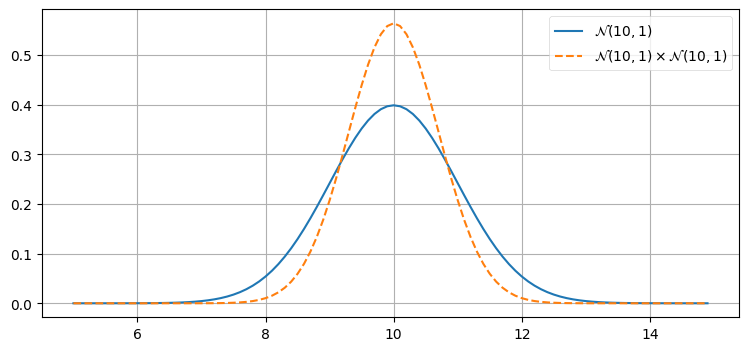

In [14]:
z = gaussian(10., 1.)  # Gaussian N(10, 1)

product = gaussian_multiply(z, z)

xs = np.arange(5, 15, 0.1)
ys = [stats.gaussian(x, z.mean, z.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')

ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$', ls='--')
plt.legend()
print(product)

乘积的结果比原始的高斯分布更高更窄，但均值保持不变。这与你的直觉一致吗？

可以把这两个高斯分布视为两次测量。如果我连续测量两次，每次都得到10米，那么我的结论应该是长度接近于10米。因此，均值应该是10。得出长度实际上是11或9.5毫米是毫无意义的。此外，对于两次测量，我比只有一次测量更有信心，因此结果的方差应该更小。

“三思而后行”是一个众所周知的格言。高斯分布的乘法是这一物理事实的数学模型。

我不太可能连续两次得到相同的测量结果。现在让我们绘制 $\mathcal{N}(10.2,\, 1) \times \mathcal{N}(9.7,\, 1)$ 的概率密度函数图。你认为结果会是什么样子？思考一下，然后再看图。

In [15]:
m = 3.3
f'$({m},{m})$'

'$(3.3,3.3)$'

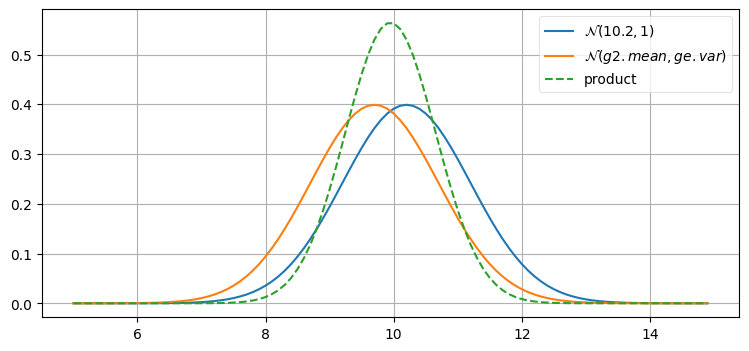

In [16]:
def plot_products(g1, g2): 
    plt.figure()
    product = gaussian_multiply(g1, g2)

    xs = np.arange(5, 15, 0.1)
    ys = [stats.gaussian(x, g1.mean, g1.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$' + f'$({g1.mean},{g1.var})$')

    ys = [stats.gaussian(x, g2.mean, g2.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$' + '$({g2.mean},{ge.var})$')

    ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
    plt.plot(xs, ys, label='product', ls='--')
    plt.legend();
    plt.show()
    
z1 = gaussian(10.2, 1)
z2 = gaussian(9.7, 1)
 
plot_products(z1, z2)

如果让两个人测量一张桌子离墙的距离，一个人得到的是10.2米，另一个人得到的是9.7米，你最好的猜测应该是这两者的平均值，如果你同样信任两者的测量技能，那么最佳猜测应该是9.95米。

回想一下g-h滤波器。我们达成共识，如果我在两台体重秤上称体重，第一台读数是160磅，而第二台读数是170磅，而且两者的准确性相同，那么最佳估计是165磅。此外，相比于160磅或170磅，我对165磅更有信心，因为现在有两个读数，都接近这个估计值，增加了我对它们都不是严重错误的信心。

在更复杂的情况下，这可能变得不那么直观，所以我们需要进一步考虑。也许更合理的假设是其中一个人犯了错误，真实的距离可能是10.2或9.7，但肯定不是9.95。这当然是可能的。但我们知道我们的测量具有噪声，所以我们没有理由认为其中一个测量没有噪声，或者其中一个人犯了严重错误，导致我们可以丢弃他们的测量。根据所有可用的信息，最佳估计值必须是9.95。

在卡尔曼滤波器的更新步骤中，我们不是将两个测量组合在一起，而是将一个测量值和先验值结合在一起，即我们在融合测量值之前的估计值。我们已经对g-h滤波器进行了这样的逻辑推理。无论我们是从两个测量值中还是从一个测量值和一个预测中获取信息，数学计算是一样的。

让我们看看这个过程。我将创建一个相当不准确的先验值 $\mathcal N(8.5, 1.5)$ 和一个更准确的测量值 $\mathcal N(10.2, 0.5)$。这里所说的“准确”是指传感器的方差比先验的方差小，而不是我以某种方式知道狗离10.2米更近还是8.5米更近。接下来，我将绘制一个相反的关系：一个准确的先验值 $\mathcal N(8.5, 0.5)$ 和一个不准确的测量值 $\mathcal N(10.2, 1.5)$。

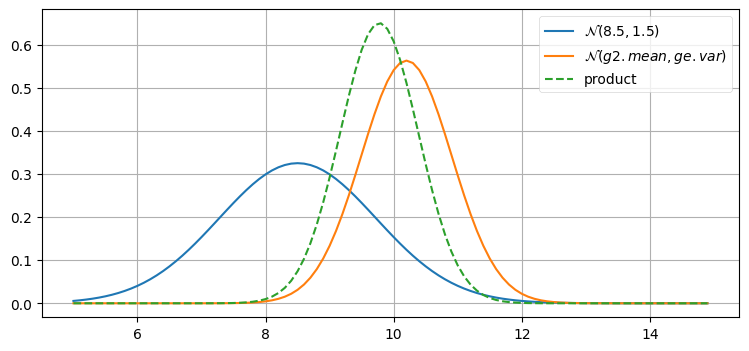

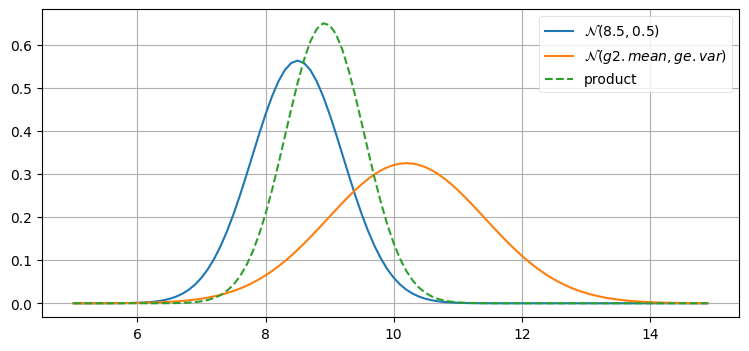

In [17]:
prior, z = gaussian(8.5, 1.5), gaussian(10.2, 0.5)
plot_products(prior, z)

prior, z = gaussian(8.5, 0.5), gaussian(10.2, 1.5)
plot_products(prior, z)

结果是一个高斯分布，比任一输入都要高。这是有道理的——我们融入了信息，所以我们的方差应该会减小。而且注意结果更接近具有较小方差的输入。我们对该值更有信心，因此更应该对其进行加权。

这个方法看起来行得通，但它真的正确吗？关于这个问题还有更多可以讨论的，但我想先让你体验一下一个可行的滤波器。之后我们将重新讨论高斯乘法，并确定其正确性。

# 交互式的例子

这段交互式代码提供了滑块，可以调整两个高斯函数的均值和方差，然后将它们相乘。当你移动滑块时，图形会重新绘制。将光标放在代码单元格内，按下 CTRL+Enter 执行它。

In [18]:
from ipywidgets import interact

def interactive_gaussian(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_products(g1, g2)
    
interact(interactive_gaussian,
         m1=(5, 10., .5), m2=(10, 15, .5), 
         v1=(.1, 2, .1), v2=(.1, 2, .1));

interactive(children=(FloatSlider(value=7.5, description='m1', max=10.0, min=5.0, step=0.5), FloatSlider(value…

# 你的第一个卡尔曼滤波器

让我们回归具体问题，并实现一个卡尔曼滤波器。我们已经实现了`update()`和`predict()`函数。我们只需要编写一些样板代码来模拟一只狗并生成测量数据。我在`kf_internal`中放置了一个`DogSimulation`类，以避免在这个任务上分心。

这个样板代码通过定义均值、方差，并生成模拟狗的移动来设置问题。

In [19]:
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation

np.random.seed(13)

process_var = 1. # variance in the dog's movement
sensor_var = 2. # variance in the sensor

x = gaussian(0., 20.**2)  # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)]

下面是卡尔曼滤波器

In [20]:
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    kf_internal.print_gh(prior, x, z)

print()
print(f'final estimate:        {x.mean:10.3f}')
print(f'actual final position: {dog.x:10.3f}')

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  401.000	1.354	  1.352   1.990
  2.352    2.990	1.882	  2.070   1.198
  3.070    2.198	4.341	  3.736   1.047
  4.736    2.047	7.156	  5.960   1.012
  6.960    2.012	6.939	  6.949   1.003
  7.949    2.003	6.844	  7.396   1.001
  8.396    2.001	9.847	  9.122   1.000
 10.122    2.000	12.553	 11.338   1.000
 12.338    2.000	16.273	 14.305   1.000
 15.305    2.000	14.800	 15.053   1.000

final estimate:            15.053
actual final position:     14.838


这是滤波器的动画。预测值用红色三角形表示。在预测之后，滤波器接收到下一个测量值，用黑色圆圈表示。然后，滤波器会形成一个介于两者之间的估计值。

In [21]:
from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider

# save output in these lists for plotting
xs, predictions = [], []

process_model = gaussian(velocity, process_var) 

# perform Kalman filter
x = gaussian(0., 20.**2)
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i])
    
    plt.xlim(-1, 10)
    plt.ylim(0, 20)
    plt.legend(loc=2);
    plt.show()
    
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=1, description='step', max=30, min=1), Output()), _dom_classes=('widget-…

我已经绘制了先验（标记为“预测”）、测量值和滤波器输出。在循环的每次迭代中，我们形成一个先验，进行一次测量，从测量中形成一个似然，然后将似然合并到先验中。

如果你看图，可以看到滤波器的估计值始终介于测量值和预测值之间。回想一下对于 g-h 滤波器，我们认为估计值必须始终介于测量值和先验值之间。选择一个超出这两个值范围之外的值是毫无意义的。如果我预测我在 10，但测量结果显示我在 9，那么假设我在 8 或 11 是愚蠢的。

# 代码详解

现在让我们来分析一下这段代码。

```python
process_var = 1.
sensor_var = 2.
```

这些是过程模型和传感器的方差。传感器方差的含义应该很清楚 - 它表示每个测量值的方差大小。而过程方差则表示了在过程模型中存在的误差。我们预测在每个时间步长中狗狗会向前移动一米。然而，狗狗很少按照我们的预期行动，像是山丘或一只松鼠的气味都会改变它的前进方向。如果这是一个响应数字指令的机器人，性能会更好，或许方差会是 $\sigma^2=.05$。这些并不是‘魔法’数字；方差的平方根是以米为单位的距离误差。仅仅通过插入数字就能使得卡尔曼滤波器运行起来，但如果这些数字不反映现实，滤波器的性能会很差。

```python
x = gaussian(0., 20.**2)
```

这是狗狗初始位置的高斯表示。位置为 0 米，方差为 400 平方米，即标准差为 20 米。你可以将其理解为：“我相信有 99.7% 的准确性，位置在 0 加减 60 米之间”。这是因为高斯分布中约 99.7% 的值落在均值的 $\pm3\sigma$ 范围内。

```python
process_model = gaussian(velocity, process_var)
```

这是过程模型 - 我们对狗狗移动方式的描述。我怎么知道速度？魔法吗？可以把它看作是一个预测，或者也许我们有一个次要的速度传感器。如果这是一个机器人，那么这将是机器人的控制输入。在后续章节中，我们会学习如何处理没有速度传感器或输入的情况，所以请暂时接受这个简化版本。

接下来我们初始化了过程模拟，并创建了 10 个测量值：

```python
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

zs = [dog.move_and_sense() for _ in range(10)]
```

现在我们进入了 `predict() ... update()` 循环。

```python
for z in zs:
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
```

循环的第一次，`prior` 是 `(1.0, 401.0)`，正如表格中所显示的。预测之后，我们相信位置在 1.0，并且方差现在变成了 401，从原本的 400 增加了一个单位。方差增大是预测步骤中总会发生的，因为这涉及到信息的丢失。

然后我们使用 `prior` 作为当前位置调用了更新函数。

对于这一步，我得到了这样的结果：`pos = (1.352, 1.990), z = 1.354`。

发生了什么？狗狗实际上在 1.0 的位置，但由于传感器噪声，测量值是 1.354。这和预测值 1 相差很远。先验的方差是 401 平方米。较大的方差意味着置信度非常低，因此滤波器估计位置非常接近测量值：1.352。

再看方差：1.99 平方米。它已经从 401 平方米大幅下降。为什么？因为 RFID 具有相对较小的方差，约为 2.0 平方米，所以我们比先验更加信任测量值。然而，先前的信念中包含了一些有用的信息，所以我们的方差现在略小于 2.0。

现在软件循环调用 `predict()` 和 `update()`。最终估计的位置是 15.053，实际位置是 14.838。方差已经收敛到 1.0 平方米。

现在看图。嘈杂的测量值用黑色圆圈表示，滤波结果用实线蓝色表示。两者都非常嘈杂，但请注意测量值的噪声要大得多。我用红色三角形绘制了预测（先验）。估计值始终位于先验和测量值之间。这是你的第一个卡尔曼滤波器，看起来运行良好！

这段代码中，滤波器的实现只有几行。大部分代码都是初始化、数据存储、模拟狗狗移动和打印结果。执行滤波的代码非常简洁：

```python
prior = predict(x, process_model)
likelihood = gaussian(z, sensor_var)
x = update(prior, likelihood)
```

如果我们没有使用`predict`和`update`函数，代码可能是这样的：

```python
for z in zs:
    # 预测
    dx = velocity*dt
    pos = pos + dx
    var = var + process_var

    # 更新
    pos  = (var*z + sensor_var*pos) / (var + sensor_var)
    var = (var * sensor_var) / (var + sensor_var)
```    

只有 5 行非常简单的数学运算就实现了整个滤波器！

在这个例子中，我只绘制了 10 个数据点，以免打印出的结果太多。现在让我们看一下使用更多数据时滤波器的性能。方差被绘制成了浅黄色区域，位于虚线之间。我增加了过程和传感器方差的大小，这样它们在图表中更容易看到 - 当然，在一个真实的卡尔曼滤波器中，你不会随意改变这些值。

	4.4502 2.6507 2.2871 2.1955 2.1712
	2.1647 2.1629 2.1625 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623


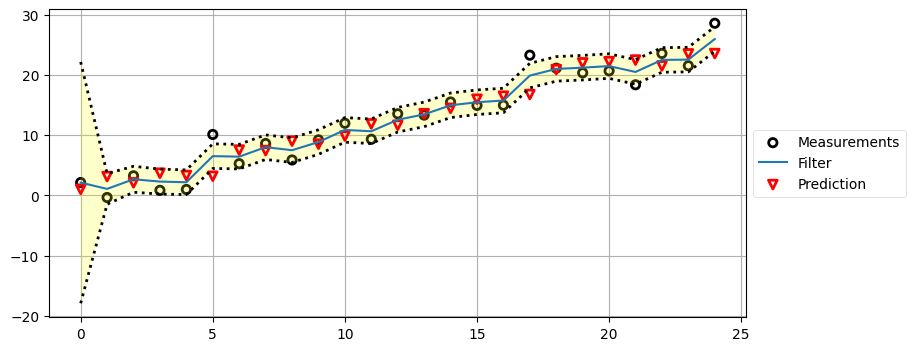

In [22]:
process_var = 2.
sensor_var = 4.5
x = gaussian(0., 400.)
process_model = gaussian(1., process_var)
N = 25

dog = DogSimulation(x.mean, process_model.mean, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

xs, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    prior = predict(x, process_model)    
    x = update(prior, gaussian(z, sensor_var))
    priors[i] = prior
    
    xs[i] = x

book_plots.plot_measurements(zs)
book_plots.plot_filter(xs[:, 0], var=priors[:, 1])
book_plots.plot_predictions(priors[:, 0])
book_plots.show_legend()
kf_internal.print_variance(xs)

在这里，我们可以看到方差在 9 步内收敛到了 2.1623。这意味着我们对位置估计非常有信心。这相当于 $\sigma=1.47$ 米。与传感器的 $\sigma=2.12$ 米相比，我们初始的不确定性使得前几次测量并不确定，但是滤波器很快就收敛到了一个比传感器方差更小的估计值！

这段代码完全实现了一个卡尔曼滤波器。如果你尝试阅读过相关文献，你可能会感到惊讶，因为这看起来与书中那些无穷无尽的数学推导完全不同。只要我们关心*使用*方程式，而不是*推导*它们，这个主题就是可以掌握的。而且，我希望你会同意，你对发生的事情有了相当直观的理解。我们用高斯分布表示信念，并且随着时间的推移，它们变得更好，因为有更多的测量值意味着我们有更多的数据可用。

# 练习：修改方差的值

更改`process_var`和`sensor_var`的值会对滤波器和方差产生影响。哪个对方差的收敛有更大的影响？例如，哪个会导致更小的方差：

```python
process_var = 40
sensor_var = 2
```
    
或者:

```python
process_var = 2
sensor_var = 40
```

# 卡尔曼滤波器动画

如果你正在浏览器中阅读这段文字，你应该能够看到一个动画，展示滤波器跟踪狗狗的轨迹，就在这句话下面。

<img src='animations/05_dog_track.gif'>

顶部的图表显示了滤波器的输出（绿色），以及虚线红线表示的测量值。底部的图表显示了每一步的高斯分布曲线。

当轨迹刚开始时，你会看到测量值与初始预测相差很大。此时高斯概率较小（曲线低而宽），因此滤波器不太相信自己的预测。结果，滤波器对估计进行了较大调整。随着滤波器的创新，你可以看到随着高斯变得更高，表明估计更加确定，滤波器的输出变得非常接近一条直线。当 `x = 15` 及更大时，你可以看到测量中有很大的噪声，但是与对第一个嘈杂测量的反应相比，滤波器对此并没有做出太大的调整。

# 卡尔曼增益

让我们回到数学部分来理解正在发生的事情。后验 $x$ 被计算为似然乘以先验（$\mathcal L \bar x$），其中两者都是高斯分布。

因此后验的均值由以下公式给出：

$$
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}
$$

我使用下标 $z$ 表示测量。我们可以将其重写为：

$$\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu$$

以这种形式，很容易看出我们通过权重来缩放测量和先验：

$$\mu = W_1 \mu_z + W_2 \bar\mu$$


这些权重之和为一，因为分母是一个归一化项。我们引入一个新术语，$K=W_1$，得到：

$$\begin{aligned}
\mu &= K \mu_z + (1-K) \bar\mu\\
&= \bar\mu + K(\mu_z - \bar\mu)
\end{aligned}$$

其中

$$K = \frac {\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$$

$K$ 是 *卡尔曼增益*。这是卡尔曼滤波器的关键所在。它是一个缩放项，选择了介于 $\mu_z$ 和 $\bar\mu$ 之间的值。

让我们进行几个示例。如果测量比先验准确度高九倍，那么 $\bar\sigma^2 = 9\sigma_z^2$，并且

$$\begin{aligned}
\mu&=\frac{9 \sigma_z^2 \mu_z + \sigma_z^2\, \bar\mu} {9 \sigma_z^2 + \sigma_\mathtt{z}^2} \\
&= \left(\frac{9}{10}\right) \mu_z + \left(\frac{1}{10}\right) \bar\mu
\end{aligned}
$$

因此 $K = \frac 9 {10}$，形成后验时我们取测量的九分之九和先验的十分之一。

如果测量和先验同等准确，那么 $\bar\sigma^2 = \sigma_z^2$，并且

$$\begin{gathered}
\mu=\frac{\sigma_z^2\,  (\bar\mu + \mu_z)}{2\sigma_\mathtt{z}^2} \\
= \left(\frac{1}{2}\right)\bar\mu + \left(\frac{1}{2}\right)\mu_z
\end{gathered}$$

这是两个均值的平均值。取两个同等准确的值的平均值是符合直觉的。

我们也可以用卡尔曼增益来表达方差：

$$\begin{aligned}
\sigma^2 &= \frac{\bar\sigma^2 \sigma_z^2 } {\bar\sigma^2 + \sigma_z^2} \\
&= K\sigma_z^2 \\
&= (1-K)\bar\sigma^2 
\end{aligned}$$

我们可以通过观察下面的图表来理解这个公式：

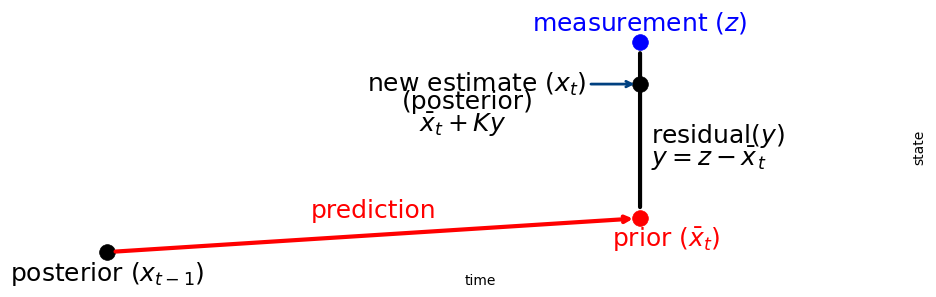

In [23]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

卡尔曼增益 $K$ 是一个缩放因子，它选择了残差路径上的一个值。这导致了`update()`和`predict()`的另一种等效实现：

In [24]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

为什么我以这种形式写，为什么选择了这些糟糕的变量名？有几个相关的原因。大多数书籍和论文都以这种形式展示卡尔曼滤波器。我从贝叶斯原理推导出滤波器的方法并不罕见，但并不常用。其他推导方法自然地导致了这种形式的方程。此外，多变量卡尔曼滤波器的方程几乎与这些方程完全相同。因此，你需要学习并理解它们。

`z`、`P`、`Q`和`R`这些变量名从何而来？你将在本书的其余部分看到它们的使用。在文献中，$R$ 几乎普遍用于表示测量噪声，$Q$ 表示过程噪声，$P$ 表示状态的方差。使用`z`表示测量是常见的，尽管并非普遍如此。你阅读的几乎每一本书和论文都会使用这些变量名。要习惯它们。

这也是一种强大的思考方式来思考滤波。这是我们推理 g-h 滤波器的方式。它强调了取残差 $y = \mu_z - \bar\mu$，将卡尔曼增益视为我们对先验和测量不确定性的比率 $K = P/(P+R)$，并通过将 $Ky$ 添加到先验来计算后验。

这种形式隐藏了贝叶斯方面，以及我们是如何将似然与先验相乘的事实。这两种观点是等价的，因为数学是相同的。我选择了贝叶斯方法，因为我认为它提供了更直观而深刻的概率推理理解。而使用 $K$ 的这种替代形式则提供了对所谓的 *正交投影* 方法的深刻理解。卡尔曼博士在发明这个滤波器时使用了那种推导方法，而不是贝叶斯推理。在接下来的几章中，你将更多地了解到这一点。

# 算法的描述

记得我们用于 g-h 滤波器的图表吗？

<img src="./figs/residual_chart.png">

我们在本章中一直在做同样的事情。卡尔曼滤波器进行预测，接受测量，然后形成介于两者之间的新估计值。

**这一点非常重要要理解**：本书中的每个滤波器都实现了相同的算法，只是数学细节不同。数学在后面的章节中可能变得复杂，但这个想法很容易理解。

重要的是要看到特定滤波器方程式的细节之外，并理解这些方程式正在计算 *什么*，以及 *为什么*。有大量的滤波器。它们都使用不同的数学来实现相同的算法。数学的选择影响结果的质量和可以表示的问题，但并不影响基本思想。

这是通用的算法：

**初始化**

    1. 初始化滤波器的状态
    2. 初始化我们对状态的信念
    
**预测**

    1. 使用系统行为预测下一个时间步的状态
    2. 调整信念以考虑预测的不确定性
    
**更新**

    1. 获取测量值及其精度相关的信念
    2. 计算估计状态和测量值之间的残差
    3. 根据测量或预测的准确性计算缩放因子
    4. 基于缩放因子设置状态在预测和测量之间
    5. 根据对测量的确定性更新对状态的信念
    
很难找到不符合这种形式的贝叶斯滤波器算法。一些滤波器可能不包括某些方面，比如对预测中的错误，而其他滤波器可能有非常复杂的计算方法，但它们都是做同样的事情。

单变量卡尔曼滤波器的方程式是：

<u>Predict</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation} & \text{Kalman Form}\\
\hline
 \bar x = x + f_x & \bar\mu = \mu + \mu_{f_x} & \bar x = x + dx\\
& \bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = P + Q\\
\hline
\end{array}$


<u>Update</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation}& \text{Kalman Form}\\
\hline
 x = \| \mathcal L\bar x\| & y = z - \bar\mu & y = z - \bar x\\
 & K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R}\\
 & \mu = \bar \mu + Ky & x = \bar x + Ky\\
 & \sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & P = (1-K)\bar P\\
\hline
\end{array}$

# 与g-h滤波器和离散贝叶斯滤波器比较

现在是理解这三种滤波器之间差异的好时机，就我们对误差建模的方式而言。对于 g-h 滤波器，我们对测量进行了如下图所示的建模：

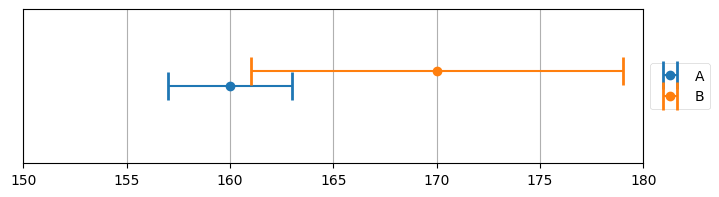

In [25]:
book_plots.plot_errorbars([(160, 3, 'A'), (170, 9, 'B')], xlims=(150, 180))

Sensor A返回了测量值160，Sensor B返回了170。柱状图上的线条代表[*误差条*](https://en.wikipedia.org/wiki/Error_bar)，它们说明了测量可能的误差范围。因此，传感器A测量的实际值可能在157到163之间，而B测量的值可能在161到179之间。

我当时没有定义它，但这是一个[*均匀分布*](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous&#41;)。均匀分布将范围内的任何事件赋予相等的概率。根据这个模型，Sensor A读取157、160或163的可能性是相等的。这些范围之外的任何值概率都为0。

我们可以用高斯分布来建模这种情况。我将使用$\mathcal{N}(160, 3^2)$表示Sensor A的分布，以及$\mathcal{N}(170, 9^2)$表示Sensor B的分布。为了进行比较，我已经将它们与均匀分布的误差条一起绘制在下面。

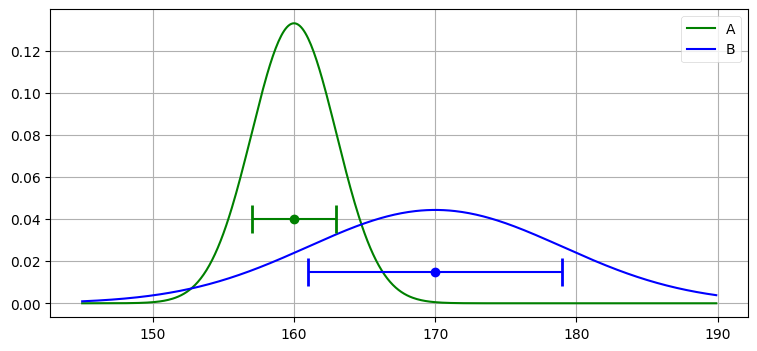

In [26]:
xs = np.arange(145, 190, 0.1)
ys = [stats.gaussian(x, 160, 3**2) for x in xs]
plt.plot(xs, ys, label='A', color='g')

ys = [stats.gaussian(x, 170, 9**2) for x in xs]
plt.plot(xs, ys, label='B', color='b')
plt.legend();
plt.errorbar(160, [0.04], xerr=[3], fmt='o', color='g', capthick=2, capsize=10)    
plt.errorbar(170, [0.015], xerr=[9], fmt='o', color='b', capthick=2, capsize=10);

使用均匀分布或高斯分布是一种建模选择。两者都不能完全描述现实。在大多数情况下，高斯分布更符合现实。大多数传感器更有可能返回接近被测量值的读数，并且不太可能返回远离该值的读数。高斯分布模拟了这种趋势。相比之下，均匀分布假设范围内的任何测量值是等可能的。

现在让我们看看离散贝叶斯滤波器中使用的*离散分布*。这个模型将可能值的范围分成离散的区间，并为每个区间分配一个概率。只要这些概率之和为一，这个分配可以完全是任意的。

让我们用均匀分布、高斯分布和离散分布来绘制一个传感器的数据。

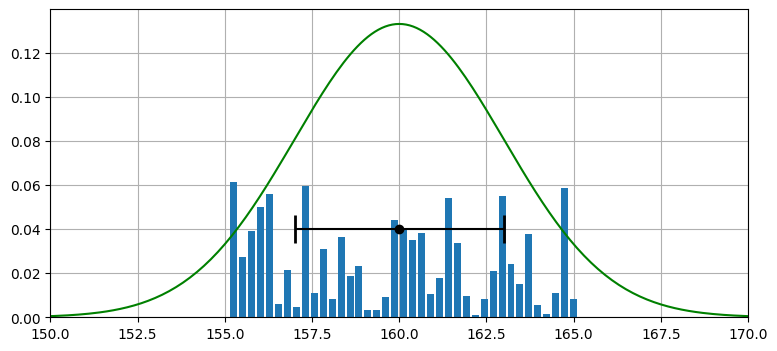

In [27]:
from random import random
xs = np.arange(145, 190, 0.1)
ys = [stats.gaussian(x, 160, 3**2) for x in xs]
belief = np.array([random() for _ in range(40)])
belief = belief / sum(belief)

x = np.linspace(155, 165, len(belief))
plt.gca().bar(x, belief, width=0.2)
plt.plot(xs, ys, label='A', color='g')
plt.errorbar(160, [0.04], xerr=[3], fmt='o', color='k', capthick=2, capsize=10)    
plt.xlim(150, 170);

我使用随机数来形成离散分布，以说明它可以模拟任意的概率分布。这赋予了它巨大的能力。通过足够多的离散区间，我们可以模拟任何传感器的误差特性，无论多么复杂。但是，这种能力带来了数学上的难以处理。将高斯分布相乘或相加只需要两行数学公式，而结果是另一个高斯分布。这种规律性使我们能够对滤波器的性能和行为进行强大的分析。将离散分布相乘或相加需要循环处理数据，并且我们没有简单的方法来描述结果。基于离散分布的滤波器性能特征分析极其困难，几乎不可能。

在这里没有“正确”的选择。在本书的后面，我们将介绍*粒子滤波器*，它使用离散分布。这是一种极其强大的技术，因为它可以处理任意复杂的情况。但这样做的代价是性能较慢，并且不易进行分析。

现在我们将忽略这些问题，并在接下来的几章中继续使用高斯分布。随着我们的进展，你将了解在数学模型中使用高斯分布的优势和局限性。

# 滤波器设计简介

到目前为止，我们已经为位置传感器开发了滤波器。现在我们已经习惯了这个问题，并且可能觉得自己缺乏能力为其他问题实现卡尔曼滤波器。说实话，这个介绍中仍然缺少相当多的信息。接下来的章节将填补这些空白。不过，让我们通过设计和实现一个用于温度计的卡尔曼滤波器来感受一下。温度计的传感器输出对应于被测量的温度的电压。我们已经阅读了传感器的制造商规格说明，它告诉我们传感器具有标准差为0.13伏的白噪声特性。

我们可以用这个函数模拟温度传感器的测量：

In [28]:
def volt(voltage, std):
    return voltage + (randn() * std)

在这个问题中，我们需要设计一个针对温度计的卡尔曼滤波器。与之前针对位置传感器的问题不同，温度计的传感器输出的是对应被测量温度的电压。我们已经了解到传感器的规格，它告诉我们传感器具有0.13伏的标准差白噪声特性。

在卡尔曼滤波器中，我们需要进行预测和更新的循环。传感步骤很清楚，调用 `volt()` 获取测量值，将结果传递给 `update()` 方法。但对于预测步骤，我们没有传感器来检测电压的变化。因此，我们将假设温度不会变化，以便进行预测。但这样的预测可能会导致滤波器对温度的变化不敏感，产生所谓的“自以为是”滤波器。为了避免这种情况，我们会在预测步骤中引入一些误差，告诉滤波器不要忽略电压随时间的变化。

在这个例子中，我设置了 `process_var = .05**2`，表示每个时间步中电压变化的预期方差。这个值是为了演示方差如何通过更新和预测步骤变化而设置的，并非实际情况下的真实值。在实际应用中，你需要根据你所测量的电压变化的实际幅度来设定这个值。例如，对于测量室内温度的传感器，这个值可能非常小；而对于化学反应室中的热电偶，这个值可能就比较大。在后续章节中，我们会更详细地讨论如何选择这个值。

这个例子中的代码将展示预测和更新步骤如何对电压进行处理，以及方差如何随着步骤变化。最终我们会看到滤波器对温度变化的反应。

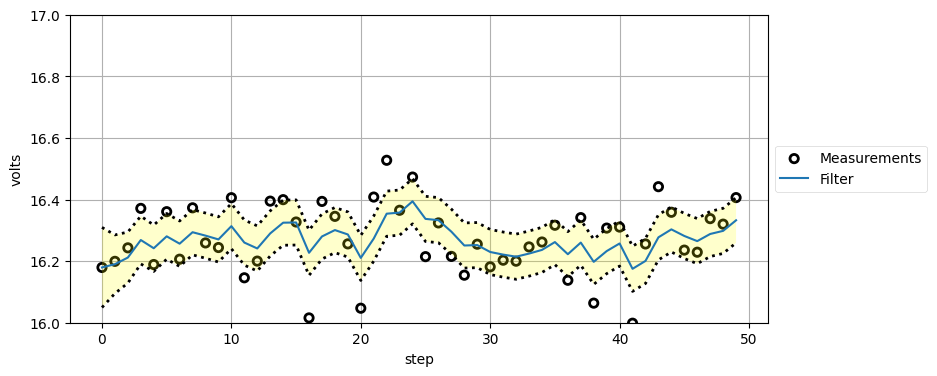

Variance converges to 0.005


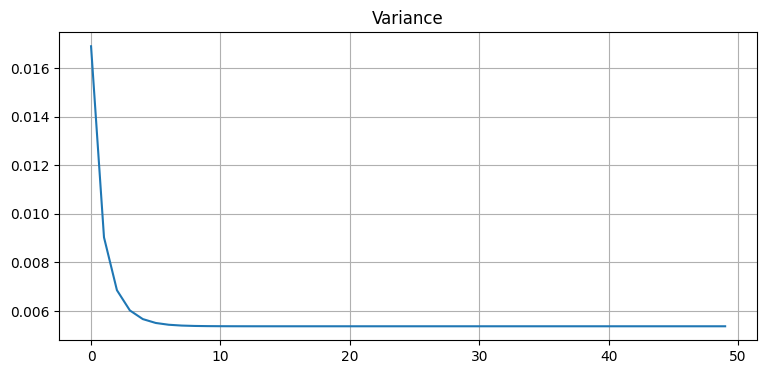

In [29]:
temp_change = 0
voltage_std = .13
process_var = .05**2
actual_voltage = 16.3

x = gaussian(25., 1000.) # initial state
process_model = gaussian(0., process_var)

N = 50
zs = [volt(actual_voltage, voltage_std) for i in range(N)]
ps = []
estimates = []

for z in zs:
    prior = predict(x, process_model)
    x = update(prior, gaussian(z, voltage_std**2))

    # save for latter plotting
    estimates.append(x.mean)
    ps.append(x.var)

# plot the filter output and the variance
book_plots.plot_measurements(zs)
book_plots.plot_filter(estimates, var=np.array(ps))
book_plots.show_legend()
plt.ylim(16, 17)
book_plots.set_labels(x='step', y='volts')
plt.show()
    
plt.plot(ps)
plt.title('Variance')
print(f'Variance converges to {ps[-1]:.3f}')

第一个图表显示了各个传感器测量值与滤波器输出之间的对比。尽管传感器存在很多噪声，但我们很快就能够确定传感器的大致电压值。在我最近完成的一次运行中，滤波器的最后一个电压输出为16.213，非常接近`volt()`函数使用的16.4。在其他运行中，我得到了更大或更小的结果。

规格说明就像它们听起来的那样 - 规格。任何单独的传感器都会基于正常的制造变化而表现出不同的性能。数值通常是最大值 - 规格是性能至少达到那么好的保证。如果你购买的是昂贵的设备，通常会附有一张显示你特定物品测试结果的纸张；这通常是非常可靠的。另一方面，如果这是一个廉价的传感器，很可能在销售之前几乎没有接受任何测试。制造商通常会对其产出的一小部分进行测试，以验证样品是否在所需性能范围内。如果你有关键应用，你需要仔细阅读规格说明，弄清楚他们对其范围的确切含义。他们是否保证了这个数字是最大值，还是例如$3\sigma$误差率？是否每个物品都经过测试？方差是否是正态分布，还是其他分布？最后，制造并不是完美的。你的零件可能有缺陷，与规格表上的性能不匹配。

例如，我正在看一个气流传感器的数据表。有一个字段叫*重复性*，值为$\pm 0.50\%$。这是一个高斯分布吗？是否有偏差？例如，重复性在低温下几乎为$0.0\%$，而在高温下总是接近$+0.50\%$。电子元件的数据表通常包含一个“典型性能特征”部分。这些用于捕捉无法在表格中轻易传达的信息。例如，我正在看一个显示LM555定时器输出电压与电流关系的图表。有三条曲线显示了不同温度下的性能。理想情况下，响应是线性的，但三条曲线都是弯曲的。这说明电压输出的误差可能不是高斯的 - 在这个芯片的情况下，温度越高，电压输出越低，如果输入电流很高，电压输出是非常非线性的。

正如你可能猜到的那样，对传感器性能进行建模是创建表现良好的卡尔曼滤波器中最困难的部分之一。

# 动画

抱歉，我无法直接在这里显示动画。你可以访问以下链接查看动画：[https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/animations/05_volt_animate.gif](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/animations/05_volt_animate.gif)

<img src='animations/05_volt_animate.gif'>

理解卡尔曼滤波器的工作方式，需要观察动画呈现的信息。动画的顶部图表绘制了几种元素：首先是用绿线表示的预测下一个电压值，然后是用红色加号表示的实际测量值，接着是用浅红色线条显示的残差，最后是表示滤波器输出的蓝线。你可以看到，在滤波器开始运行时，所做的校正非常大，但只经过几次更新后，即使测量值与输出值相差很远，滤波器的调整也变得很小。

底部图表展示了随着滤波器创新的高斯信念。当滤波器启动时，高斯曲线位于25附近，即我们对电压的初始猜测值，并且由于初始的不确定性，曲线非常宽而矮。但随着滤波器的创新，高斯曲线迅速移动到约16.0，并变得更高，反映了滤波器对电压估计的增强信心。你也会注意到高斯曲线的高度有些起伏。如果仔细观察，你会发现在预测步骤中，高斯曲线变得更矮更分散，而在滤波器融合另一个测量值时，高斯曲线变得更高更窄。

用g-h滤波器的思路来理解这个动画。在每个步骤中，g-h滤波器进行预测、获取测量值、计算残差（预测与测量值之间的差异），然后根据缩放因子$g$在残差线上选择一个点。卡尔曼滤波器做的事情完全相同，只是缩放因子$g$随时间变化。随着滤波器对其状态的信心增强，缩放因子倾向于选择滤波器的预测结果，而不是测量值。

# 示例：极端噪音

通过在RFID传感器中注入更多噪音来模拟更接近真实世界的条件，同时保持处理方差为2平方米。我将注入极端数量的噪音——这种噪音显然会淹没实际测量。如果传感器的标准偏差达到300米，你的直觉对于滤波器的性能会有什么看法呢？换句话说，1.0米的实际位置可能会报告为287.9米，或者-589.6米，或者大致在这个范围内的任何其他数字。在你继续之前思考一下。

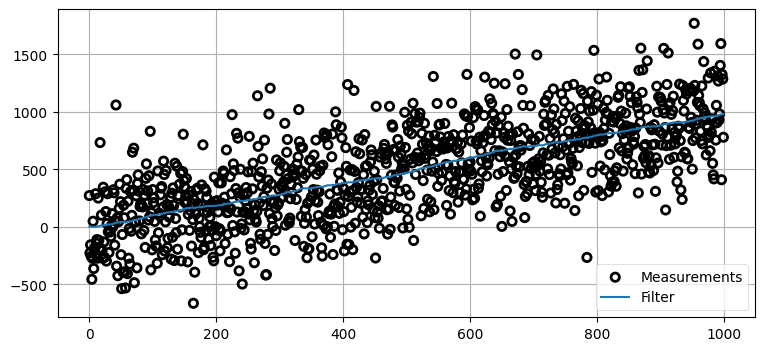

In [30]:
sensor_var = 300.**2
process_var = 2.
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 1000
dog = DogSimulation(pos.mean, 1., sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for i in range(N):
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(zs[i], sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

在这个例子中，即使噪音非常极端，滤波器仍然输出了一个几乎是直线的结果！这是一个惊人的结果！你认为这种性能的原因可能是什么呢？

我们得到几乎是一条直线，是因为我们的过程误差很小。较小的过程误差告诉滤波器预测是非常可信的，而且预测是一条直线，因此滤波器输出几乎是一条直线。

# 示例： 不正确的流程差异

那最后一个滤波器看起来不错！为什么我们不把过程方差设得非常低，因为这样可以确保结果是直且平滑的？

过程方差告诉滤波器系统随时间变化的程度。如果你故意将这个数字设得非常低，就相当于在欺骗滤波器，滤波器就无法对正在发生的变化做出反应。让我们让狗在每个时间步长内略微增加速度，看看在过程方差为0.001平方米的情况下滤波器的表现如何。

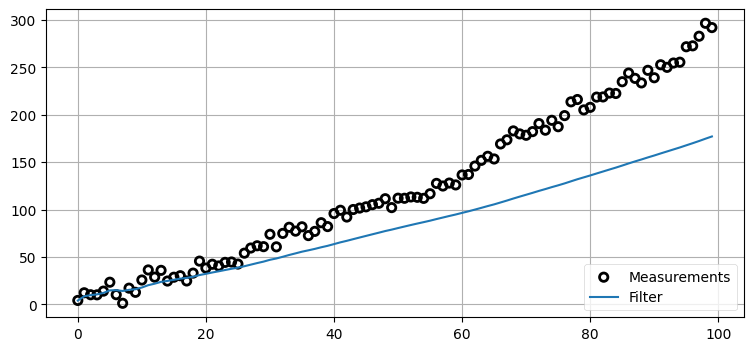

In [31]:
sensor_var = 20.
process_var = .001
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 100
dog = DogSimulation(pos.mean, 1, sensor_var, process_var*10000)
zs, ps = [], []
for _ in range(N):
    dog.velocity += 0.04
    zs.append(dog.move_and_sense())

for z in zs:
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

很容易看出，滤波器没有正确地对测量作出反应。测量明确表明狗的速度在改变，但滤波器被告知其预测几乎是完美的，因此它几乎完全忽略了这些测量。我鼓励你调整狗的移动量与过程方差之间的关系。我们也将在后续章节中更深入地研究这个问题。关键是要认识到，数学要求方差正确描述你的系统。滤波器并不会“注意到”它与测量值的偏差并对其进行修正。它根据先验和测量的方差计算卡尔曼增益，并根据哪个更准确来形成估计。

# 示例： 糟糕的初始估算

现在让我们看看当我们对位置做出错误的初始估计时的结果。为了不掩盖结果，我将把传感器方差减小到30，但将初始位置设定为1000米。滤波器能够从1000米的错误中恢复过来吗？

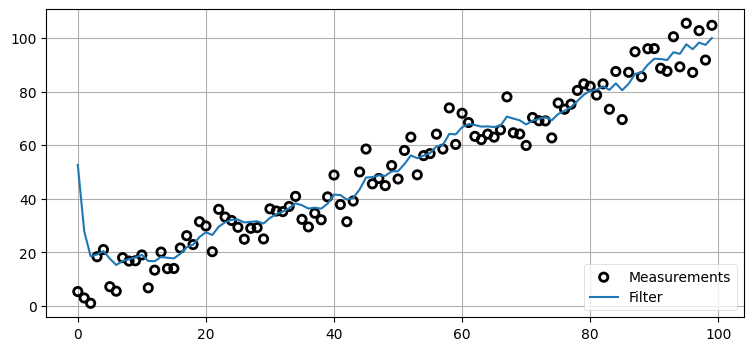

In [32]:
sensor_var = 5.**2
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)
N = 100
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

没错！因为我们对传感器的信念相对较高（$σ^2=5^2$），所以在第一步之后，我们将位置估计从1000米左右改变到大约50米。再经过另外5-10次测量，我们已经收敛到了正确的值。实际上，我们可能会将传感器的第一次测量值分配为初始值，但你可以看到，如果我们对初始条件进行了荒谬的猜测，卡尔曼滤波器仍然会收敛，只要滤波器的方差选择与实际的过程和测量方差相匹配即可。

# 示例： 噪声大、初始估计差

那么，噪音大和初始估算错误这两种最糟糕的情况又如何呢？

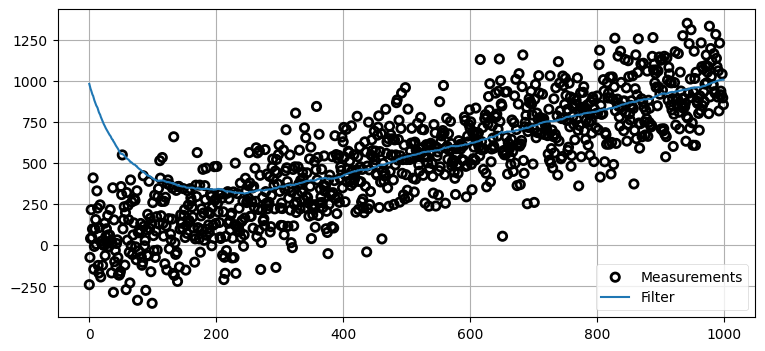

In [33]:
sensor_var = 30000.
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)

N = 1000
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model) 
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

这次滤波器遇到了困难。注意，之前的示例只进行了100次更新，而这个示例使用了1000次。从我的角度看，滤波器大约需要400次迭代才能变得相当准确，但也许需要超过600次才能得到良好的结果。卡尔曼滤波器很强大，但我们不能指望奇迹。如果我们的数据非常嘈杂，并且初始条件非常糟糕，那么这就是最好的效果了。

最后，让我们实现使用第一次测量作为初始位置的建议。

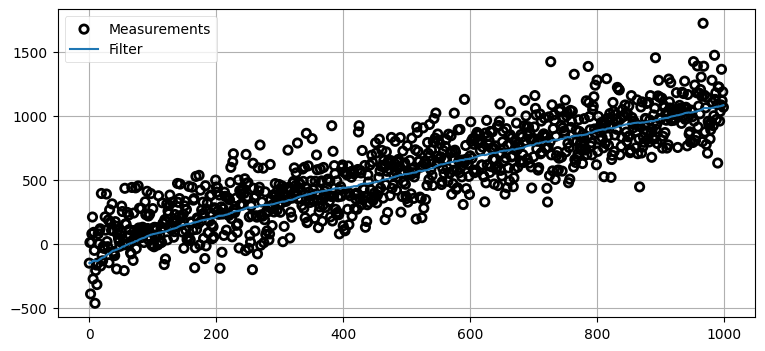

In [34]:
sensor_var = 30000.
process_var = 2.
process_model = gaussian(1., process_var)
N = 1000
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

pos = gaussian(zs[0], 500.)
ps = []
for z in zs:
    prior = predict(pos, process_model) 
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc='best');

这个简单的变化显著改善了结果。在一些运行中，需要大约200次迭代才能收敛到一个良好的解决方案，但在其他运行中，它收敛得非常迅速。这完全取决于第一次测量中噪音的数量。大量的噪音会导致初始估计远离狗的位置。

200次迭代可能看起来很多，但我们注入的噪音量确实非常巨大。在现实世界中，我们使用诸如温度计、激光测距仪、GPS 卫星、计算机视觉等传感器。这些传感器都不会有这些示例中的巨大误差。一个廉价温度计的合理方差可能是 0.2 C$^{\circ 2}$，而我们的代码使用的是 30,000 C$^{\circ 2}$。

#  练习：交互式绘图

利用Jupyter Notebook的动画功能实现卡尔曼滤波器，让你能够使用滑块实时修改各种常数。参考**高斯**章节中的**交互式高斯**部分，看看如何实现这一点。你将使用`interact()`函数调用一个计算和绘图的函数。传递给`interact()`的每个参数都会自动创建一个滑块。我已经写好了模板代码，你只需填写所需的代码即可。

In [35]:
from ipywidgets import interact
from kf_book.book_plots import FloatSlider

def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       velocity, 
                       process_noise):
    plt.figure();
    # your code goes here

interact(plot_kalman_filter,
         start_pos=(-10, 10), 
         sensor_noise=FloatSlider(value=5, min=0, max=100), 
         velocity=FloatSlider(value=1, min=-2., max=2.), 
         process_noise=FloatSlider(value=5, min=0, max=100.));


interactive(children=(IntSlider(value=0, description='start_pos', max=10, min=-10), FloatSlider(value=5.0, con…

# 答案

一个可能的解决方案如下。我们有滑块来调整起始位置、传感器噪音、每个时间步长的移动量以及移动误差的大小。过程噪音可能是最不清楚的——它模拟了狗在每个时间步长中偏离轨迹的程度，因此我们在每一步中将其添加到狗的位置上。我设置了随机数生成器的种子，这样每次重新绘制都会使用相同的随机数，让我们能够在移动滑块时比较图表。

In [37]:
from numpy.random import seed 
from ipywidgets import interact

def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       velocity,
                       process_noise):
    N = 20
    zs, ps = [], []   
    seed(303)
    dog = DogSimulation(start_pos, velocity, sensor_noise, process_noise)
    zs = [dog.move_and_sense() for _ in range(N)]
    pos = gaussian(0., 1000.) # mean and variance
    process_model = gaussian(velocity, process_noise)
    
    for z in zs:    
        pos = predict(pos, process_model)
        pos = update(pos, gaussian(z, sensor_noise))
        ps.append(pos.mean)

    plt.figure()
    plt.plot(zs, c='k', marker='o', linestyle='', label='measurement')
    plt.plot(ps, c='#004080', alpha=0.7, label='filter')
    plt.legend(loc=4);
    plt.show()

interact(plot_kalman_filter,
         start_pos=(-10, 10), 
         sensor_noise=FloatSlider(value=5, min=0., max=100), 
         velocity=FloatSlider(value=1, min=-2., max=2.), 
         process_noise=FloatSlider(value=.1, min=0, max=40));

interactive(children=(IntSlider(value=0, description='start_pos', max=10, min=-10), FloatSlider(value=5.0, con…

# 练习：非线性系统

我们的卡尔曼滤波器的方程是线性的：

$$\begin{aligned}
\mathcal{N}(\bar\mu,\, \bar\sigma^2) &= \mathcal{N}(\mu,\, \sigma^2) + \mathcal{N}(\mu_\mathtt{move},\, \sigma^2_\mathtt{move})\\
\mathcal{N}(\mu,\, \sigma^2) &= \mathcal{N}(\bar\mu,\, \bar\sigma^2)  \times \mathcal{N}(\mu_\mathtt{z},\, \sigma^2_\mathtt{z})
\end{aligned}$$

你认为这个滤波器在非线性系统中表现良好还是不佳呢？

实现一个使用以下方程生成测量值的卡尔曼滤波器：

```python
for i in range(100):
    z = math.sin(i/3.) * 2
```

调整方差和初始位置，观察其影响。例如，一个非常糟糕的初始猜测会导致什么结果？

# 答案

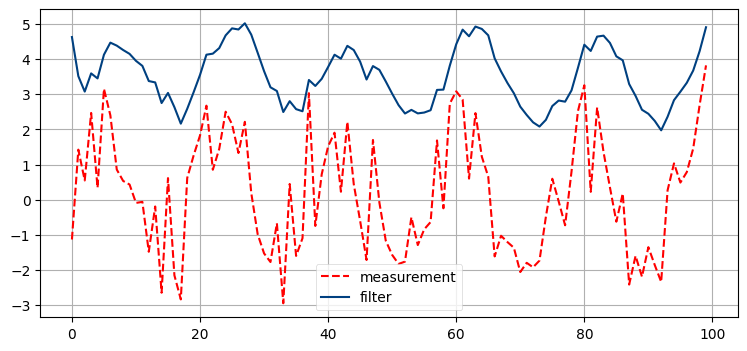

In [38]:
import math

sensor_var = 30.
process_var = 2.
pos = gaussian(100., 500.)
process_model = gaussian(1., process_var)

zs, ps = [], []

for i in range(100):
    pos = predict(pos, process_model)

    z = math.sin(i/3.)*2 + randn()*1.2
    zs.append(z)
    
    pos = update(pos, gaussian(z, sensor_var))
    ps.append(pos.mean)

plt.plot(zs, c='r', linestyle='dashed', label='measurement')
plt.plot(ps, c='#004080', label='filter')
plt.legend(loc='best');

# 讨论

这太糟糕了！输出结果根本不像正弦波，除非在最粗略的程度上。在线性系统中，我们可以给信号添加极大量的噪声，仍然能够提取非常精确的结果，但在这里，即使是适度的噪声也会导致非常糟糕的结果。

如果我们回忆一下**g-h滤波器**章节，就能理解这里发生了什么。g-h滤波器的结构要求滤波器输出值在预测值和测量值之间选择一个部分值。而像这样变化的信号总是在加速，而我们的过程模型假设恒定速度，因此滤波器在数学上保证始终落后于输入信号。

在实践者开始实现卡尔曼滤波器后不久，他们意识到它们在非线性系统中表现很差，并开始设法解决这个问题。后来的章节都致力于解决这个问题。

# 固定的滤波器增益

嵌入式计算机通常具有极其有限的处理器性能。许多设备甚至没有浮点运算电路。这些简单的方程可能会给芯片带来沉重的负担。随着技术的进步，情况有所改善，但当你需要购买数百万台处理器时，节省一美元的价值绝不可小视。

在上面的例子中，滤波器的方差会收敛到一个固定值。如果测量和过程的方差是常数，这种情况总是会发生。你可以利用这个事实通过运行模拟来确定方差收敛到的值。然后，你可以将这个值硬编码到你的滤波器中。只要你将滤波器初始化为一个良好的起始猜测（我建议使用第一个测量值作为初始值），滤波器的性能将非常好。例如，狗追踪滤波器可以简化为以下形式：

```python
def update(x, z):
    K = .13232  # 实验得出的卡尔曼增益
    y = z - x   # 残差
    x = x + K*y # 后验值
    return x
    
def predict(x):
    return x + vel*dt
```

我使用了更新函数中的卡尔曼增益形式来强调我们根本不需要考虑方差。如果方差收敛到一个单一值，卡尔曼增益也会如此。

# FilterPy 的实现

FilterPy实现了`predict()`和`update()`。它们不仅适用于本章中开发的单变量情况，还适用于我们在后续章节中学习的更一般的多变量情况。因此，它们的接口稍有不同。它们不是将高斯分布作为元组传入，而是作为两个分别命名的变量。

`predict()`接受了几个参数，但我们只需要使用其中的四个：

```python
predict(x, P, u, Q)
```

`x`是系统的状态。`P`是系统的方差。`u`是由过程产生的运动，而`Q`是过程中的噪声。在调用`predict()`时，你需要使用命名参数，因为大多数参数都是可选的。`predict()`的第三个参数 **不是** `u`。

这些变量名也许会让你觉得糟糕。确实如此！正如我之前提到的，它们来自于控制理论的悠久历史，你阅读的每一篇论文或书籍都会使用这些名称。因此，我们只能习惯接受它们。拒绝记住它们意味着你将永远无法阅读相关文献。

让我们尝试一下，状态为$\mathcal N(10, 3)$，运动为$\mathcal N(1, 4)$。我们预期最终位置为11（10+1），方差为7（3+4）。

In [39]:
import filterpy.kalman as kf
kf.predict(x=10., P=3., u=1., Q=4.)

(11.0, 7.0)

`update`也接受了几个参数，但现在你可能对其中的四个感兴趣：

```python
update(x, P, z, R)
```

与之前一样，`x`和`P`分别是系统的状态和方差。`z`是测量值，`R`是测量方差。让我们执行最后一个`predict`语句以获得我们的先验值，然后执行一个`update`：

In [40]:
x, P = kf.predict(x=10., P=3., u=1., Q=2.**2)
print(f'{x:.3f}')

x, P = kf.update(x=x, P=P, z=12., R=3.5**2)
print(f'{x:.3f} {P:.3f}')

11.000
11.364 4.455


我给了一个方差很大的嘈杂测量，所以估计值保持在先验值11附近。

最后一个要点。我没有在预测步骤的输出中使用变量名`prior`。在本书的其余部分，我也不会使用那个变量名。卡尔曼滤波器方程只使用$\mathbf x$。先验值和后验值都是系统估计的状态，前者是在测量被合并之前的估计值，后者是在测量被合并之后的值。

# 总结

我们在本章描述的卡尔曼滤波器是我们接下来将学习的更一般滤波器的一个特殊、受限制的情况。大多数文献不讨论这个一维形式。然而，我认为这是一个至关重要的基础。我们从g-h滤波器开始，然后实现了离散贝叶斯滤波器，现在又实现了一维卡尔曼滤波器。我试图向你展示这些滤波器都使用相同的算法和推理。不久我们将学习的卡尔曼滤波器的数学内容相当复杂，很难理解滤波器的基本简单性。但这种复杂性带来了显著的好处：通用滤波器在性能上远远超出了本章的滤波器。

这一章需要时间消化。要真正理解它，你可能需要多次学习这一章。我鼓励你修改代码中的各种常数并观察结果。说服自己高斯分布是描述走廊中狗的位置、天空中飞机的位置或化学反应室温度的单峰信念的良好表示。然后说服自己，将高斯分布相乘确实计算了新的信念，基于先前的信念和新的测量。最后，说服自己，如果你在测量运动，将高斯分布相加会更新你的信念。

最重要的是，花足够的时间来理解**算法的完整描述**部分，确保你理解算法及其与g-h滤波器和离散贝叶斯滤波器的关系。这里只有一个“技巧”——在预测和测量之间选择一个值。每个算法都用不同的数学方法执行这个“技巧”，但都使用相同的逻辑。